# Урок 4. Формулируем задачу в терминах ML.

## Описание системы

В рамках данного проекта разрабатывается система для прогнозирования сроков строительства базовых станций сотовой связи.<br />
Отличительной особенностью системы является то, что на начальных этапах отсутствует вся информация о ключевых этапах технологического процесса.
1. На начальном этапе известны только параметры присущие самому планируемому объекту связи, такие как, место размещения, тип объекта, технологии, которые планируется строить, сопряженные объекты связи. По этим данным система прогнозирует предварительный срок строительства объекта связи. На данном этапе допустима точность прогнозирования в пределах одного квартала.
2. По мере работы над строительством базовой станции появляются даты важных производственных этапов. Каждый дополнительный шаг производственного процесса приводит к появлению дополнительного признака, который уточняет прогноз. Прогнозы с момента эатапа выдачи оборудования должны быть в пределах недели.
3. Кроме уже описанного с помощью системы должна быть предусмотрена возможность прогнозирования сроков каждого из этапов строительства.

## Загрузка и очистка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt

%matplotlib inline
SEED = 16

### Датасет

В качестве набора данных используем выгрузку из системы управления проектами за 2023, 2024 годы обфусцированную по чувствительным данным. 

In [3]:
url = 'https://github.com/morebobah/MFDP/raw/refs/heads/main/Task_4_Formulate_The_Task_Using_The_ML_Terms/o_19999.csv'
df = pd.read_csv(url, index_col=0) # Загружаем данные
df.describe() # и просматриваем описание датасета

,year,INTEGRATION_5G,MONITORING_ASSEPTANCE_5G,COMMISSIONING_5G,idleft,idright,2g,3g,4g,rrl,a_index
count,19999.000000,0.0,0.0,0.0,1.999900e+04,1.999900e+04,7508.0,7413.0,19525.0,2557.0,19999.000000
mean,2023.343717,NaN,NaN,NaN,9.467952e+05,9.064633e+04,1.0,1.0,1.0,1.0,390847.358518
std,0.474960,NaN,NaN,NaN,1.892546e+06,5.914757e+05,0.0,0.0,0.0,0.0,189243.373878
min,2023.000000,NaN,NaN,NaN,1.140000e+02,1.440000e+02,1.0,1.0,1.0,1.0,61428.000000
25%,2023.000000,NaN,NaN,NaN,6.689000e+04,1.880000e+02,1.0,1.0,1.0,1.0,302527.000000
50%,2023.000000,NaN,NaN,NaN,2.844770e+05,1.880000e+02,1.0,1.0,1.0,1.0,392347.000000
75%,2024.000000,NaN,NaN,NaN,6.720395e+05,1.880000e+02,1.0,1.0,1.0,1.0,573728.000000
max,2024.000000,NaN,NaN,NaN,9.514423e+06,9.509531e+06,1.0,1.0,1.0,1.0,694921.000000


Датасет содержит 19999 строк, каждая строка соответствует работам по одному объекту связи. В описании видно, что есть неинформативные поля содержащие нулевые значания. Поля с нулевыми значениями удаляем.

In [5]:
NotNeededFields = ['INTEGRATION_5G', 'MONITORING_ASSEPTANCE_5G', 'COMMISSIONING_5G'] # все касается технологии 5g, её в 23, 24 году не строили
for fld in NotNeededFields:
    df = df.drop(fld, axis=1)

Смотрим на содержимое набора данных.

In [7]:
df.head()

,year,type_of_work,altername,contractor,date_start,date_fin,INTEGRATION_2G,INTEGRATION_3G,INTEGRATION_4G,INTEGRATION_TRM,...,PLAN_IS_READY,idleft,idright,2g,3g,4g,rrl,a_index,a_region,a_place
id,,,,,,,,,,,,,,,,,,,,,
1000040,2024,existing,work2334,contractor24,2022-08-26,2024-10-31,NaN,NaN,2024-10-31 12:02:00,NaN,...,NaN,1368441,188,NaN,NaN,1.0,NaN,139277,region14,urban
1000392,2023,new,work6981,contractor32,2022-09-12,2023-03-03,2023-03-02 15:39:00,NaN,2023-03-02 15:39:00,NaN,...,2023-02-15 08:23:00,53841,188,1.0,NaN,1.0,NaN,139086,region14,suburban
1000393,2023,new,work8181,contractor30,2022-09-12,2023-03-02,2023-03-01 16:22:00,NaN,2023-03-01 16:23:00,NaN,...,2023-02-14 10:16:00,53941,188,1.0,NaN,1.0,NaN,139100,region14,suburban
1000396,2023,new,work16610,contractor30,2022-09-12,2023-03-03,2023-03-03 13:21:00,NaN,2023-03-03 13:21:00,NaN,...,2023-02-15 08:23:00,54041,188,1.0,NaN,1.0,NaN,138822,region14,suburban
1000398,2023,new,work5393,contractor30,2022-09-12,2023-03-03,2023-03-02 15:39:00,NaN,2023-03-02 15:40:00,NaN,...,2023-02-15 08:24:00,54141,188,1.0,NaN,1.0,NaN,139181,region14,suburban


#### Описание полей датасета
<table>
    <tr>
        <th>Наименование поля</th>
        <th>Тип данных</th>
        <th>Тип признака</th>
        <th>Описание</th>
    </tr>
    <tr>
        <td>id</td>
        <td>Целочисленный</td>
        <td>Индекс</td>
        <td>Уникальный идентификатор работ</td>
    </tr>
    <tr>
        <td>year</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Год проведения работ</td>
    </tr>
    <tr>
        <td>type_of_work</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Тип работ, новое строительство или модернизация существующего</td>
    </tr>
    <tr>
        <td>altername</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Название работ</td>
    </tr>
    <tr>
        <td>contractor</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Название подрядной организации выполняющей работы</td>
    </tr>
    <tr>
        <td>date_start</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата регистрации работ в системе</td>
    </tr>
    <tr>
        <td>date_fin</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Отметка о дате окончания работ</td>
    </tr>
    <tr>
        <td>INTEGRATION_2G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>INTEGRATION_3G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>INTEGRATION_4G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>INTEGRATION_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата интеграции по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_2G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_3G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_4G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>MONITORING_ASSEPTANCE_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата приемки готового объекта в мониторинг по технологиям</td>
    </tr>
    <tr>
        <td>COMMISSIONING_2G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата ввода в эксплуатацию по технологиям</td>
    </tr>
    <tr>
        <td>COMMISSIONING_3G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата ввода в эксплуатацию по технологиям</td>
    </tr>
    <tr>
        <td>COMMISSIONING_4G</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата ввода в эксплуатацию по технологиям</td>
    </tr>
    <tr>
        <td>EQUIPMENT_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>EQUIPMENT_ENERGO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>EQUIPMENT_STUFF</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>EQUIPMENT_RADIO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности заявки на оборудования по компонентам объекта связи</td>
    </tr>
    <tr>
        <td>CONSRACTION_READINESS</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата строительной готовности</td>
    </tr>
    <tr>
        <td>EQUIPMENT_PREPARED</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата комплектации оборудования</td>
    </tr>
    <tr>
        <td>INSTALL_BS</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата монтажа технологического оборудования</td>
    </tr>
    <tr>
        <td>INSTALL_ENERGO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата монтажа энергетического оборудования</td>
    </tr>
    <tr>
        <td>READY_FOR_WORK</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности к пуско-наладочным работам</td>
    </tr>
    <tr>
        <td>PARAMS_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности параметров для транспорта данных</td>
    </tr>
    <tr>
        <td>PARAMS_RADIO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности радиопараметров</td>
    </tr>
    <tr>
        <td>ASSERT_FOR_WORK</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности к пуско-наладочным работам</td>
    </tr>
    <tr>
        <td>ADR_PREPARE</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата начала работ по объекту</td>
    </tr>
    <tr>
        <td>TECH_TASK_TRM</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности технического задания по транспорту</td>
    </tr>
    <tr>
        <td>TECH_TASK_ENERGO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности технического задания по энергетике</td>
    </tr>
    <tr>
        <td>TECH_TASK_RADIO</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата готовности технического задания по радиочасти</td>
    </tr>
    <tr>
        <td>TECH_TASK_CONTRACTOR</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата передачи работ подрядчику</td>
    </tr>
    <tr>
        <td>CONTRACTOR_ACCEPTED</td>
        <td>Дата и время</td>
        <td>Временной</td>
        <td>Дата начала работ подрядчика</td>
    </tr>
    <tr>
        <td>idleft</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор объекта связи</td>
    </tr>
    <tr>
        <td>idright</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор сопряженного объекта связи</td>
    </tr>
    <tr>
        <td>2g</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>3g</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>4g</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>a_index</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Признак места размещения объекта</td>
    </tr>
    <tr>
        <td>a_region</td>
        <td>Текстовый</td>
        <td>Категориальный</td>
        <td>Регион размещения объекта</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Текстовый</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
</table> 

In [9]:
#Типы полей
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 1000040 to 1161382
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       19999 non-null  int64  
 1   type_of_work               19999 non-null  object 
 2   altername                  19999 non-null  object 
 3   contractor                 19999 non-null  object 
 4   date_start                 19999 non-null  object 
 5   date_fin                   19999 non-null  object 
 6   INTEGRATION_2G             7438 non-null   object 
 7   INTEGRATION_3G             7235 non-null   object 
 8   INTEGRATION_4G             19557 non-null  object 
 9   INTEGRATION_TRM            2591 non-null   object 
 10  MONITORING_ASSEPTANCE_2G   7418 non-null   object 
 11  MONITORING_ASSEPTANCE_3G   7217 non-null   object 
 12  MONITORING_ASSEPTANCE_4G   19538 non-null  object 
 13  MONITORING_ASSEPTANCE_TRM  2529 non-null   

Из предыдущего списка видно, что многие типы данных в полях не соответсвуют тем типам, которые в них содержатся. Проведем преобразование полей с датами к типу данных datetime. Поля с датами содержатся в столбцах имеющих названия записанные загравными буквами плюс к этим столбцам добавляются столбцы date_start, date_fin, их преобразуем отдельно:

In [11]:
#Все поля с заглавными буквами даты, плюс поля date_start, date_fin
fld = [x for x in df.columns if x==x.upper()] #+ ['date_start', 'date_fin']
for f in fld:
    df[f] = pd.to_datetime(df[f], format='%Y-%m-%d %H:%M:%S')
df['date_start'] = pd.to_datetime(df['date_start'], format='%Y-%m-%d')
df['date_fin'] = pd.to_datetime(df['date_fin'], format='%Y-%m-%d')

Заметим, что некоторые столбцы относятся к разным частям одного и того же этапа технологического процесса. Например, столбцы TECH_TASK_TRM, TECH_TASK_ENERGO, TECH_TASK_RADIO, TECH_TASK_CONTRACTOR фиксируют время готовности разных частей техничского задания, при этом для дальнейшей работы требуется все техничское задание целиком, поэтому набор этих столбцов можно преобразовать в одно поле содержащее самую большую дату. Объединим все такие поля и запишем их в результирующий датасет.

In [13]:
fields = {'tech': ['TECH_TASK_TRM', 'TECH_TASK_ENERGO', 'TECH_TASK_RADIO', 'TECH_TASK_CONTRACTOR'],
          'equipment': ['EQUIPMENT_TRM', 'EQUIPMENT_ENERGO', 'EQUIPMENT_STUFF', 'EQUIPMENT_RADIO'], 
          'integration': ['INTEGRATION_2G', 'INTEGRATION_3G', 'INTEGRATION_4G', 'INTEGRATION_TRM'], 
          'monitoring': ['MONITORING_ASSEPTANCE_2G', 'MONITORING_ASSEPTANCE_3G', 'MONITORING_ASSEPTANCE_4G', 'MONITORING_ASSEPTANCE_TRM'], 
          'commisioning': ['COMMISSIONING_2G', 'COMMISSIONING_3G', 'COMMISSIONING_4G'], 
          'params': ['PARAMS_TRM', 'PARAMS_RADIO']}
for key, val in fields.items():
    df[key+'_fin'] = df[val].max(axis=1)

Создадим набор полей содержащих промежутки времени между различными событиями технологического процесса.

In [15]:
df['delta_all'] = (df['date_fin'] - df['date_start'])/timedelta(days=1) #Все время работ в днях
df['delta_start'] = (df['ADR_PREPARE'] - df['date_start'])/timedelta(days=1) #Время от добавления в систему до начала работ
df['delta_tech'] = (df['tech_fin'] - df['ADR_PREPARE'])/timedelta(days=1) #Время от начала работ до готовности технической части
df['delta_spe'] = (df['equipment_fin'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до заказа оборудования
df['delta_equipment'] = (df['EQUIPMENT_PREPARED'] - df['equipment_fin'])/timedelta(days=1) #Время от начала работ до комплектации
df['delta_contractor'] = (df['CONTRACTOR_ACCEPTED'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до проектирования
df['delta_ready'] = (df['READY_FOR_WORK'] - df['EQUIPMENT_PREPARED'])/timedelta(days=1) #Время от комплектации до готовности к пуску
df['delta_params'] = (df['params_fin'] - df['READY_FOR_WORK'])/timedelta(days=1) #Время от готовности к пуску до готовности параметров
df['delta_integration'] = (df['integration_fin'] - df['params_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_monitoring'] = (df['monitoring_fin'] - df['integration_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_commisioning'] = (df['commisioning_fin'] - df['monitoring_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции

Оставляем копию датасета на данном этапе, для возможности дальнейшего анализа данных.

In [17]:
df_analysis = df.copy(deep=True)

Заменяем категориальные данные числовыми значениями для возможности использовать набор в задаче регрессии. 

In [19]:
fields = ['type_of_work', 'altername', 'contractor', 'a_region', 'a_place']
for fld in fields:
    print(fld)
    d = df[fld].value_counts().to_dict().keys()
    for idx, condition in enumerate(d):
        df.loc[df[fld] == condition, fld] = idx * 1.0
    df[fld] =  df[fld].astype(float)

type_of_work
altername
contractor
a_region
a_place


Удаяем поля, которые не будут участвовать в обучении модели.

In [21]:
fields = ['year', 'type_of_work', 'contractor', 'idleft', 'idright', 
          '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place',
          'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 
          'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration',
          'delta_monitoring', 'delta_commisioning', 'delta_all']
target = len(fields) - 1 #Целевое поле
df = df[fields]

Убираем пустые значения из результирующего набора данных.

In [25]:
empty_fields = df.columns[df.isnull().any()].tolist()
for fld in empty_fields:
    df[fld] = df[fld].fillna(0)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 1000040 to 1161382
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                19999 non-null  int64  
 1   type_of_work        19999 non-null  float64
 2   contractor          19999 non-null  float64
 3   idleft              19999 non-null  int64  
 4   idright             19999 non-null  int64  
 5   2g                  19999 non-null  float64
 6   3g                  19999 non-null  float64
 7   4g                  19999 non-null  float64
 8   rrl                 19999 non-null  float64
 9   a_index             19999 non-null  int64  
 10  a_region            19999 non-null  float64
 11  a_place             19999 non-null  float64
 12  delta_start         19999 non-null  float64
 13  delta_tech          19999 non-null  float64
 14  delta_spe           19999 non-null  float64
 15  delta_equipment     19999 non-null  float64
 16  d

Результирующий набор содержит следующие поля:
<table>
    <tr>
        <th>Наименование поля</th>
        <th>Тип данных</th>
        <th>Тип признака</th>
        <th>Описание</th>
    </tr>
    <tr>
        <td>id</td>
        <td>Целочисленный</td>
        <td>Индекс</td>
        <td>Уникальный идентификатор работ</td>
    </tr>
    <tr>
        <td>year</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Год проведения работ</td>
    </tr>
    <tr>
        <td>contractor</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Номер подрядной организации</td>
    </tr>
    <tr>
        <td>idleft</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор объекта связи</td>
    </tr>
    <tr>
        <td>idright</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор сопряженного объекта связи</td>
    </tr>
    <tr>
        <td>2g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>3g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>4g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>a_index</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Признак места размещения объекта</td>
    </tr>
    <tr>
        <td>a_region</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Регион размещения объекта</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Вещественный</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Вещественный</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
    <tr>
        <td>delta_start</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от добавления в систему до начала работ</td>
    </tr>
    <tr>
        <td>delta_tech</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от начала работ до готовности технической части</td>
    </tr>
    <tr>
        <td>delta_spe</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности технической части до заказа оборудования</td>
    </tr>
    <tr>
        <td>delta_equipment</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от начала работ до комплектации</td>
    </tr> 
    <tr>
        <td>delta_contractor</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности технической части до проектирования</td>
    </tr>  
    <tr>
        <td>delta_ready</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от комплектации до готовности к пуску</td>
    </tr> 
    <tr>
        <td>delta_params</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до готовности параметров</td>
    </tr> 
    <tr>
        <td>delta_integration</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до интеграции</td>
    </tr> 
    <tr>
        <td>delta_monitoring</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до интеграции</td>
    </tr> 
    <tr>
        <td>delta_all</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Все время работ в днях</td>
    </tr> 
</table>

## Анализ данных

In [29]:
from scipy.stats import f_oneway, shapiro, mannwhitneyu, probplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns

**Проверим гипотезу:** средняя длительность строительства зависит от региона<br />
$H_0$: Среднее время строительства одинаково для всех регионов.<br />
$H_1$: Среднее время строительства зависит от региона и статистически значимо отличается от региона к региону.<br />
Проверяем на уровне значимости $\alpha = 0.05$ для двухсторонней альтернативы.

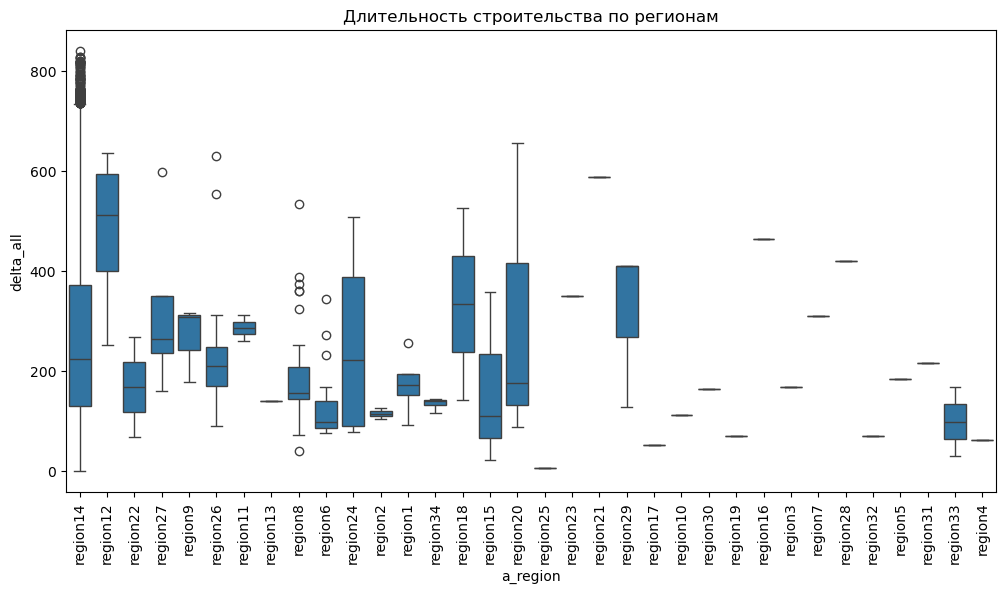

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_analysis, x='a_region', y='delta_all')
plt.xticks(rotation=90)
plt.title('Длительность строительства по регионам')
plt.show()

In [33]:
regions_groups = []
for name, group in df_analysis.groupby('a_region'):
    if group['delta_all'].std() > 0:
        regions_groups.append(group['delta_all'].values)
f_stat, p_value = f_oneway(*regions_groups)
print(f"ANOVA p-value: {p_value:.4f}")

ANOVA p-value: 0.0460


$p-value<0.05$ значит, отвергаем $H_0$ гипотезу, зависимость скорости строительства от региона есть. 

**Проверим гипотезу:** городские объекты (a_place = urban) строятся быстрее сельских<br />
$H_0$: Среднее время строительства одинаково для городских и загородных объектов связи.<br />
$H_1$: Среднее время строительства городских объектов быстрее загородных.<br />
Проверяем на уровне значимости $\alpha = 0.05$ для односторонеей альтернативы.

In [35]:
df_sample = df_analysis.sample(n=3000, random_state=SEED) # Выбираем 4000 случайных величины 
urban = df_sample[df_sample['a_place'] == 'urban']['delta_all'] # Отделяем выборки для городских
suburban = df_sample[df_sample['a_place'] == 'suburban']['delta_all'] # И загородных объектов
#Проверяем подчиняются ли выборки нормальному распределению с помощью критерия Шапиро-Уилка:
_, p_urban = shapiro(urban)
_, p_suburban = shapiro(suburban)
p_urban, p_suburban

(6.877098613682203e-30, 2.7731825683770586e-27)

Вычисленные значения критерия Шапиро-Уилка указывают на то, что данные распределены не нормально. Но, данная характеристика может давать неверные значения на больших выборках, дополнительно проверяем распределение с помощью q-q плот.

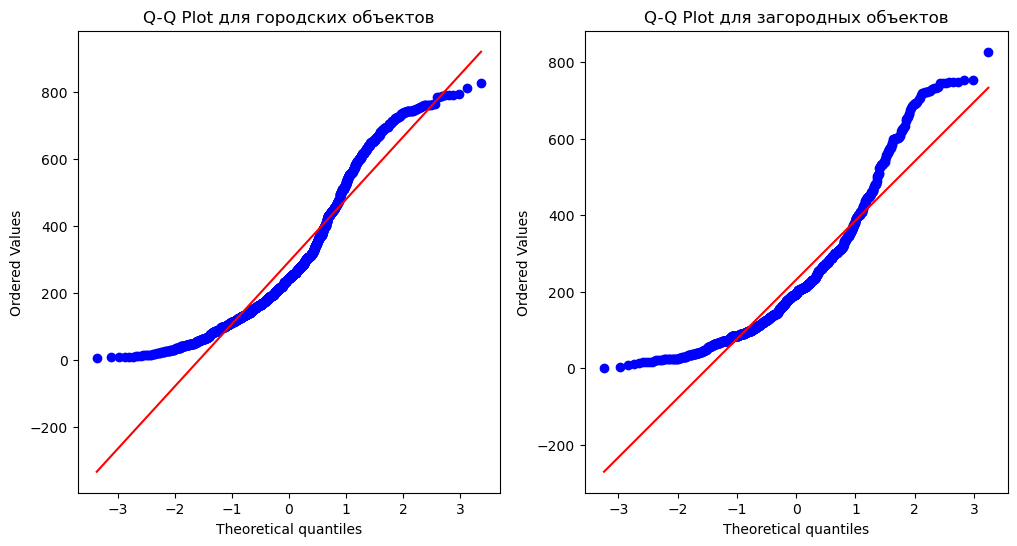

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
probplot(urban, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot для городских объектов')
probplot(suburban, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot для загородных объектов')
plt.show()

Данные распределены не нормально, на графиках тяжелые хвосты. Для проверки гипотезы используем критерий Манна-Уитни.

In [39]:
u_stat, p_value = mannwhitneyu(urban, suburban)
print(f"Mann-Whitney U p-value: {p_value:.4f}")

Mann-Whitney U p-value: 0.0000


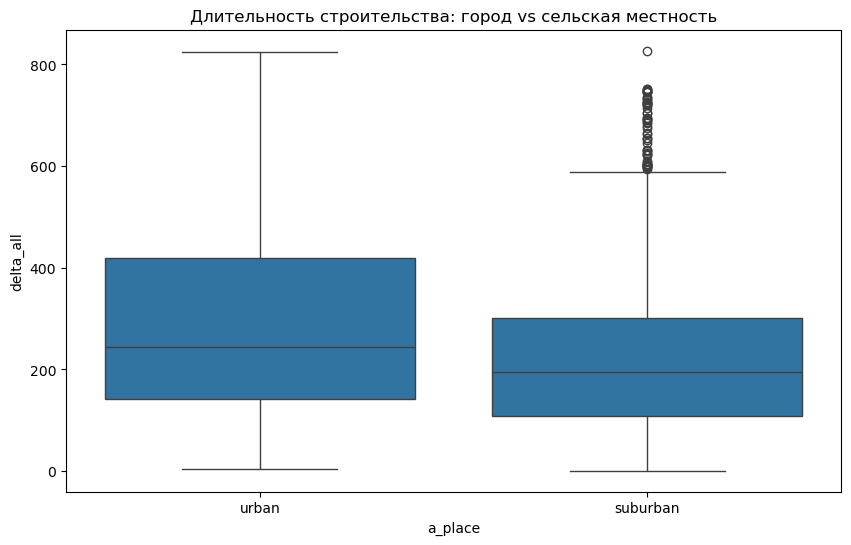

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='a_place', y='delta_all', data=df_sample)
plt.title("Длительность строительства: город vs сельская местность")
plt.show()

Разобъем данные на кластеры по признаку a_region.

In [43]:
NUM_CLUSTERS = 5

df_region = df.groupby('a_region').agg({
    'delta_all': ['mean', 'median'],
    '2g': 'sum',
    '3g': 'sum',
    '4g': 'sum',
    'rrl': 'sum',
    'a_place': 'count',
}).reset_index()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_region)
kmeans = KMeans(n_clusters=NUM_CLUSTERS)
df_region['cluster'] = kmeans.fit_predict(X_scaled)
#dbscan = DBSCAN(eps=0.5, min_samples=5)
#df_region['cluster'] = dbscan.fit_predict(X_scaled)

C:\Users\vladi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [45]:
df_region.cluster.value_counts().to_dict().keys()

dict_keys([4, 0, 2, 3, 1])

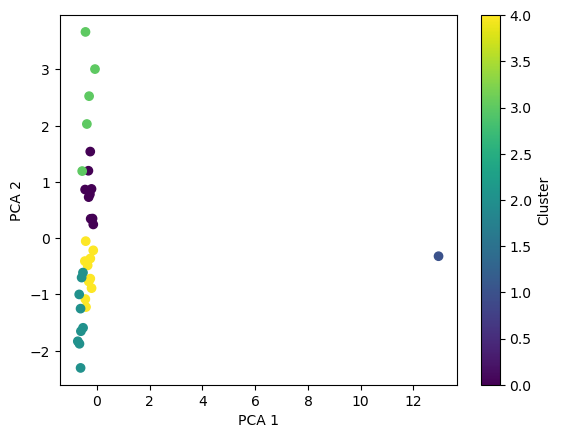

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_region['cluster'], cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()

In [49]:
df_clustered = df.copy(deep=True)
df_clustered['cluster'] = 4
for cluster in df_region.cluster.value_counts().to_dict().keys():
    regions_in_cluster = df_region[df_region.cluster == cluster].a_region
    df_clustered.loc[df_clustered.a_region.isin(regions_in_cluster), 'cluster'] = cluster

Да, уж, наверное стоило это проверить с самого начала, но кластеры получились сильно не сбалансированными. Обучать модели по отдельности не кажется целесообразным. Попробуем этот прием на следующем этапе, если получится раздобыть данные из других регионов.

## Выбор метрик

В данной системе решаем задачу регрессии. Для этой задачи возможно использовать следующие метрики:<br />
1. MSE (Mean Squared Error) – Среднеквадратическая ошибка<br />
Расчитываем по формуле:
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
- Чем меньше, тем лучше.
- Штрафует большие ошибки сильнее (из-за квадрата).
- Чувствительна к выбросам.
3. RMSE (Root Mean Squared Error) – Корень из среднеквадратической ошибки<br />
Расчитываем по формуле:
$$RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$
- Интерпретируем в тех же единицах, что и целевая переменная.
- Также чувствительна к выбросам.
5. MAE (Mean Absolute Error) – Средняя абсолютная ошибка<br />
Расчитываем по формуле:
$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$
- Менее чувствительна к выбросам, чем MSE/RMSE.
- Удобно интерпретировать (средняя ошибка в единицах целевой переменной).
7. R² (Коэффициент детерминации)<br />
Расчитываем по формуле:
$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$
- Показывает долю дисперсии, объяснённую моделью.
- Диапазон: от $-\infty$ - $+\infty$ до 1 (чем ближе к 1, тем лучше).
- Может быть отрицательным, если модель хуже, чем предсказание средним.
9. MAPE (Mean Absolute Percentage Error) – Средняя абсолютная процентная ошибка<br />
Расчитываем по формуле:
$$MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$$
- Выражается в процентах, удобно для бизнес-интерпретации.
- Не работает, если есть нулевые значения $y_i$.
11. MSLE (Mean Squared Logarithmic Error) – Среднеквадратическая логарифмическая ошибка<br />
Расчитываем по формуле:
$$MSLE = \frac{1}{n} \sum_{i=1}^{n} (\log(1 + y_i) - \log(1 + \hat{y}_i))^2$$
- Полезна, когда целевая переменная имеет экспоненциальный рост.
- Менее чувствительна к большим отклонениям, чем MSE.
13. Huber Loss – Комбинированная метрика (L1 + L2)<br />
Расчитываем по формуле:
$$L_\delta = 
\begin{cases} 
\frac{1}{2} (y_i - \hat{y}_i)^2, & \text{если } |y_i - \hat{y}_i| \leq \delta \\
\delta |y_i - \hat{y}_i| - \frac{1}{2} \delta^2, & \text{иначе}
\end{cases}$$
- Менее чувствительна к выбросам, чем MSE.
- Используется в оптимизации (например, в градиентном бустинге).

Планируется использовать несколько моделей и для общего их сравнения принято использовать одну из метрик: MSE, RMSE, MAE. Поскольку в данных содержится большое количество выбросов, что видно на графике отображающем яжщики с усами, то оптимальным вариантом из трех указанных метрик является MSE. 
В качестве второй метрики выбираем R2-score который объясняет долю дисперсии которую объясняет модель.
В ходе обучения модели будем стремиться уменьшить MAE и приблизить R2-score к единице.

## Выбор моделей

In [51]:
import optuna, joblib
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [53]:
metrics = []


Для обучения выберем три модели: линейную регрессию, случайны лес и xgboost.
Для каждой модели делаем каскадные предсказания, сначала предсказываем delta_start затем delta_tech и т.д.

### Линейная регрессия

In [55]:
#обучаем модель линейной регрессии имея только delta_start затем delta_tech и т.д.
lr_models = []
target = 22
features = 12
lr_metrics = []
for idx in range(features, target):
    print("********************************************")
    print(f"Шаг {idx - features + 1}")
    subfields = fields[:idx  + 1]
    print(f"Predict {fields[target]} with features {subfields}")
    X = df[subfields]
    y = df[fields[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    lr_models.append(LinearRegression())
    lr_models[-1].fit(X_train, y_train)
    y_pred = lr_models[-1].predict(X_test)
    print("Коэффициенты модели:", lr_models[-1].coef_)
    print("Свободный член (intercept):", lr_models[-1].intercept_)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    print("Средняя абсолютная ошибка (MAE):", MAE)
    print("Коэффициент детерминации (R²):", R2)
    lr_metrics.append((MAE, R2))

metrics.append(lr_metrics)

********************************************
Шаг 1
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start']
Коэффициенты модели: [ 2.01490510e+02 -9.39386451e+01  1.82764169e+00 -3.81857317e-06
 -8.11998983e-07  7.96623308e+01  7.88056806e+01  1.11588910e+02
  3.36223564e+01  4.76586848e-05 -1.75170006e+00 -1.15964283e+01
  7.26663247e-01]
Свободный член (intercept): -407627.67236189585
Средняя абсолютная ошибка (MAE): 92.60901328192683
Коэффициент детерминации (R²): 0.5788945388521274
********************************************
Шаг 2
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech']
Коэффициенты модели: [ 8.28588001e+01 -3.52882739e+01  9.86206501e-01 -2.00523937e-06
 -2.38876752e-06  3.60101564e+01  3.54125701e+01  5.46365371e+01
 -5.57026564e+00  

In [57]:
#Сохраняем модели чтобы не ждать их обучения
for idx in range(features, len(fields) - 1):
    joblib.dump(lr_models[idx - features], f'lr_model_{fields[idx]}.pkl')

### Случайный лес

Для случайного леса используем optuna для подбора оптимальных параметров.

In [59]:
rf_models = [] # В список сохраняем обученные модели с лучшими параметрами
target = 22 # Все поля хрнятся в списке fields, переменная target указывает на целевой атрибут
features = 12
rf_metrics = []
# Подготавливаем необхоодимые функции
# Для подбора параметров 
def objective(trial, X_train, X_test, y_train, y_test):
    """Функция для подбора параметров"""
    # Определяем пространство поиска параметров
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': SEED,
        'n_jobs': -1
    }
    
    # Создаем и обучаем модель
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    # Делаем предсказания и вычисляем метрики
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae # Можно оптимизировать по MAE или R2 - выбираем MAE

def RFOptimazeAndLearn(step, feature, rf_model):
    idx = feature + step - 1
    print("********************************************")
    print(f"Шаг {step}")
    subfields = fields[:idx + 1]
    print(f"Predict delta_all with features {subfields}")
    X = df[subfields]
    y = df[fields[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
        
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=50, show_progress_bar=False)
    best_params = study.best_params
    print(best_params)
        
    rf_model.append(RandomForestRegressor(**best_params, random_state=42, n_jobs=-1))
    rf_model[-1].fit(X_train, y_train)
    y_pred = rf_model[-1].predict(X_test)
    MAE, R2 = mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    print("Средняя абсолютная ошибка (MAE):", MAE)
    print("Коэффициент детерминации (R²):", R2)
    return MAE, R2

In [61]:
rf_metrics.append( RFOptimazeAndLearn(1, features, rf_models) ) # Предсказываем delta_all имея только delta_start

[I 2025-06-27 08:26:21,326] A new study created in memory with name: no-name-16b08668-7364-4e38-8977-ba147b995f3d


********************************************
Шаг 1
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start']


[I 2025-06-27 08:26:32,346] Trial 0 finished with value: 82.45177621980294 and parameters: {'n_estimators': 1644, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 82.45177621980294.
[I 2025-06-27 08:26:33,251] Trial 1 finished with value: 65.52217706124179 and parameters: {'n_estimators': 261, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 65.52217706124179.
[I 2025-06-27 08:26:35,077] Trial 2 finished with value: 61.91479804993583 and parameters: {'n_estimators': 388, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 61.91479804993583.
[I 2025-06-27 08:26:41,629] Trial 3 finished with value: 57.19654850326786 and parameters: {'n_estimators': 1429, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'lo

{'n_estimators': 1532, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 46.68038021618494
Коэффициент детерминации (R²): 0.8613729383209077


In [63]:
rf_metrics.append( RFOptimazeAndLearn(2, features, rf_models) ) # Добавляем delta_tech

[I 2025-06-27 08:43:58,576] A new study created in memory with name: no-name-a94db05e-480f-4cc6-b55c-cb780cd40835


********************************************
Шаг 2
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech']


[I 2025-06-27 08:44:01,665] Trial 0 finished with value: 31.36236394519656 and parameters: {'n_estimators': 211, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 31.36236394519656.
[I 2025-06-27 08:44:03,502] Trial 1 finished with value: 42.246414705165414 and parameters: {'n_estimators': 397, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 31.36236394519656.
[I 2025-06-27 08:44:09,098] Trial 2 finished with value: 46.28862387935867 and parameters: {'n_estimators': 727, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 31.36236394519656.
[I 2025-06-27 08:44:11,361] Trial 3 finished with value: 31.280081040612735 and parameters: {'n_estimators': 281, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqr

{'n_estimators': 1934, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 29.462298340955574
Коэффициент детерминации (R²): 0.9330701358892082


In [64]:
rf_metrics.append( RFOptimazeAndLearn(3, features, rf_models) ) # Добавляем delta_spe 

[I 2025-06-27 09:07:09,444] A new study created in memory with name: no-name-426c27cd-7038-40c6-b1f1-6e7c2b715d79


********************************************
Шаг 3
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe']


[I 2025-06-27 09:07:47,611] Trial 0 finished with value: 32.94961885905478 and parameters: {'n_estimators': 1524, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 32.94961885905478.
[I 2025-06-27 09:08:18,547] Trial 1 finished with value: 26.13630151216464 and parameters: {'n_estimators': 1527, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 26.13630151216464.
[I 2025-06-27 09:08:23,522] Trial 2 finished with value: 64.12173922626137 and parameters: {'n_estimators': 1142, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 26.13630151216464.
[I 2025-06-27 09:08:58,219] Trial 3 finished with value: 39.56864277788448 and parameters: {'n_estimators': 1987, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None,

{'n_estimators': 1411, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 23.385901858436505
Коэффициент детерминации (R²): 0.9539031457966727


In [65]:
rf_metrics.append( RFOptimazeAndLearn(4, features, rf_models) ) # Добавляем delta_equipment 

[I 2025-06-27 09:32:43,047] A new study created in memory with name: no-name-2bc10480-669f-4c71-a5b1-7c4080a0b710


********************************************
Шаг 4
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment']


[I 2025-06-27 09:33:55,442] Trial 0 finished with value: 28.797615589068197 and parameters: {'n_estimators': 1818, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 28.797615589068197.
[I 2025-06-27 09:34:01,014] Trial 1 finished with value: 30.748698165108316 and parameters: {'n_estimators': 364, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 28.797615589068197.
[I 2025-06-27 09:34:09,716] Trial 2 finished with value: 25.7179602512544 and parameters: {'n_estimators': 804, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 2 with value: 25.7179602512544.
[I 2025-06-27 09:34:11,645] Trial 3 finished with value: 27.943169893285138 and parameters: {'n_estimators': 172, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sq

{'n_estimators': 1424, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 22.538913333447564
Коэффициент детерминации (R²): 0.9565636550290871


In [66]:
rf_metrics.append( RFOptimazeAndLearn(5, features, rf_models) ) # Добавляем delta_contractor 

[I 2025-06-27 09:56:15,743] A new study created in memory with name: no-name-d25c1bcd-8425-4fd0-9d54-ea0da740e280


********************************************
Шаг 5
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor']


[I 2025-06-27 09:56:41,357] Trial 0 finished with value: 25.634448415337772 and parameters: {'n_estimators': 1899, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 25.634448415337772.
[I 2025-06-27 09:56:56,944] Trial 1 finished with value: 22.63051908252907 and parameters: {'n_estimators': 471, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 22.63051908252907.
[I 2025-06-27 09:57:07,421] Trial 2 finished with value: 52.19130562224628 and parameters: {'n_estimators': 1388, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 22.63051908252907.
[I 2025-06-27 09:57:54,431] Trial 3 finished with value: 25.190015177144087 and parameters: {'n_estimators': 1843, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features'

{'n_estimators': 1063, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 22.092643055453927
Коэффициент детерминации (R²): 0.9568696535872759


In [67]:
rf_metrics.append( RFOptimazeAndLearn(6, features, rf_models) ) # Добавляем delta_ready 

[I 2025-06-27 10:21:54,538] A new study created in memory with name: no-name-79cdf1fe-f0ba-40a8-b8a6-6f67ea66e06e


********************************************
Шаг 6
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready']


[I 2025-06-27 10:21:56,016] Trial 0 finished with value: 25.95077208093327 and parameters: {'n_estimators': 111, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 25.95077208093327.
[I 2025-06-27 10:22:00,413] Trial 1 finished with value: 46.92144297082115 and parameters: {'n_estimators': 501, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 25.95077208093327.
[I 2025-06-27 10:22:49,080] Trial 2 finished with value: 21.445699467605024 and parameters: {'n_estimators': 1216, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 21.445699467605024.
[I 2025-06-27 10:23:09,352] Trial 3 finished with value: 26.68068966896444 and parameters: {'n_estimators': 1526, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': '

{'n_estimators': 1827, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 20.950492213440434
Коэффициент детерминации (R²): 0.9596083285942699


In [68]:
rf_metrics.append( RFOptimazeAndLearn(7, features, rf_models) ) # Добавляем delta_params 

[I 2025-06-27 11:01:57,246] A new study created in memory with name: no-name-4729c46f-ea65-4da1-abb7-1ec7ec096c08


********************************************
Шаг 7
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params']


[I 2025-06-27 11:02:02,680] Trial 0 finished with value: 74.15320242560657 and parameters: {'n_estimators': 1165, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 74.15320242560657.
[I 2025-06-27 11:02:20,023] Trial 1 finished with value: 26.16379755152941 and parameters: {'n_estimators': 1137, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 26.16379755152941.
[I 2025-06-27 11:02:21,804] Trial 2 finished with value: 27.970030470477177 and parameters: {'n_estimators': 149, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 26.16379755152941.
[I 2025-06-27 11:02:35,087] Trial 3 finished with value: 27.19391141615298 and parameters: {'n_estimators': 796, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features':

{'n_estimators': 1763, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 21.49063314643009
Коэффициент детерминации (R²): 0.9585767240035928


In [69]:
rf_metrics.append( RFOptimazeAndLearn(8, features, rf_models) ) # Добавляем delta_integration 

[I 2025-06-27 11:27:47,236] A new study created in memory with name: no-name-b34257b0-7aa8-4313-9784-ef7be11aa6a9


********************************************
Шаг 8
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration']


[I 2025-06-27 11:27:50,403] Trial 0 finished with value: 24.304653133861823 and parameters: {'n_estimators': 211, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 24.304653133861823.
[I 2025-06-27 11:28:00,209] Trial 1 finished with value: 25.03806056348118 and parameters: {'n_estimators': 638, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 24.304653133861823.
[I 2025-06-27 11:28:24,589] Trial 2 finished with value: 31.805632752158793 and parameters: {'n_estimators': 1889, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 24.304653133861823.
[I 2025-06-27 11:28:26,763] Trial 3 finished with value: 22.5958604555848 and parameters: {'n_estimators': 124, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features'

{'n_estimators': 778, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Средняя абсолютная ошибка (MAE): 20.880762482207
Коэффициент детерминации (R²): 0.9616754423171856


In [70]:
rf_metrics.append( RFOptimazeAndLearn(9, features, rf_models) ) # Добавляем delta_monitoring 

[I 2025-06-27 11:48:29,936] A new study created in memory with name: no-name-990df0d4-c929-4d45-839d-13636a791a9a


********************************************
Шаг 9
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring']


[I 2025-06-27 11:51:06,300] Trial 0 finished with value: 24.830280263011105 and parameters: {'n_estimators': 1742, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 24.830280263011105.
[I 2025-06-27 11:51:12,934] Trial 1 finished with value: 35.798997197933026 and parameters: {'n_estimators': 557, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 24.830280263011105.
[I 2025-06-27 11:51:24,657] Trial 2 finished with value: 26.307323259343853 and parameters: {'n_estimators': 759, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 24.830280263011105.
[I 2025-06-27 11:51:38,351] Trial 3 finished with value: 39.3184519669992 and parameters: {'n_estimators': 1262, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features'

{'n_estimators': 1479, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}
Средняя абсолютная ошибка (MAE): 18.02089014096049
Коэффициент детерминации (R²): 0.9645130988352218


In [71]:
rf_metrics.append( RFOptimazeAndLearn(10, features, rf_models) ) # Добавляем delta_commisioning   

[I 2025-06-27 12:17:37,715] A new study created in memory with name: no-name-296ee3c3-d2b8-4621-8e72-13fb20ebfafc


********************************************
Шаг 10
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning']


[I 2025-06-27 12:17:41,445] Trial 0 finished with value: 22.397100055893127 and parameters: {'n_estimators': 191, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 22.397100055893127.
[I 2025-06-27 12:18:23,180] Trial 1 finished with value: 23.786243811952573 and parameters: {'n_estimators': 1926, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 22.397100055893127.
[I 2025-06-27 12:18:55,766] Trial 2 finished with value: 29.363938554174187 and parameters: {'n_estimators': 1959, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 22.397100055893127.
[I 2025-06-27 12:19:10,464] Trial 3 finished with value: 26.214358087682218 and parameters: {'n_estimators': 942, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_feat

{'n_estimators': 698, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Средняя абсолютная ошибка (MAE): 21.783958277549726
Коэффициент детерминации (R²): 0.9591304760787317


In [72]:
metrics.append(rf_metrics) # Сохраняем полученные метрики для сравнения
for idx in range(features, len(fields)-1):
    joblib.dump(rf_models[idx - features], f'rf_model_{fields[idx]}.pkl')

### XGBoost

In [85]:
#обучаем модель линейной регрессии для каскадных предсказаний, сначала предсказываем delta_start затем delta_tech и т.д.
ROUNDS = 100
xgb_models = []
target = 22
features = 12
xgb_metrics = []
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.5,
    'lambda': 1.0,
    'seed': 16
}
# подготавливаем необходимые функции
def objective(trial, X, y):
    # Определяем пространство поиска параметров
    params = {
        'objective': 'reg:absoluteerror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'alpha': trial.suggest_float('alpha', 0, 1),
        'lambda': trial.suggest_float('lambda', 0, 1),
        'seed': 16
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    num_round = ROUNDS
    
    model = xgb.train(
        params,
        dtrain,
        num_round,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    y_pred = model.predict(dtest)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

def XGBOptimazeAndLearn(step, feature, rf_model, params):
    idx = feature + step - 1
    print("********************************************")
    print(f"Шаг {step}")
    subfields = fields[:idx + 1]
    print(f"Predict delta_all with features {subfields}")
    X = df[subfields]
    y = df[fields[target]]

    # Оптимизация гиперпараметров с помощью Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)

    print(f"Лучшие параметры для {fields[idx]}:")
    print(study.best_params)
    print(f"Лучший MAE: {study.best_value:.4f}")

    # Обучение модели с лучшими параметрами
    best_params = study.best_params
    best_params['objective'] = 'reg:absoluteerror'
    best_params['eval_metric'] = 'mae'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    
    num_round = 800
    
    xgb_models.append(xgb.train(
                                best_params,
                                dtrain,
                                num_round,
                                evals=evals,
                                early_stopping_rounds=50,  # Увеличим терпение для ранней остановки
                                verbose_eval=20
                            )
                        )
    y_pred = xgb_models[-1].predict(dtest)
    print("\nМетрики качества:")
    MAE, R2 = mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    print(f"Средняя абсолютная ошибка (MAE): {MAE}")
    print(f"Коэффициент детерминации (R²): {R2}")
    return MAE, R2

In [87]:
xgb_metrics.append( XGBOptimazeAndLearn(1, features, xgb_models, params) ) # Предсказываем delta_all только с delta_start

[I 2025-06-27 12:54:46,464] A new study created in memory with name: no-name-0d0472d9-6801-442b-a6af-f1e83318ac61


********************************************
Шаг 1
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start']


[I 2025-06-27 12:54:47,664] Trial 0 finished with value: 82.97821915245056 and parameters: {'learning_rate': 0.01831748066396526, 'max_depth': 3, 'subsample': 0.6454830409228939, 'colsample_bytree': 0.6796457922974526, 'alpha': 0.10511201961820715, 'lambda': 0.9076999526676927}. Best is trial 0 with value: 82.97821915245056.
[I 2025-06-27 12:54:49,180] Trial 1 finished with value: 49.57176495039463 and parameters: {'learning_rate': 0.14708751667686934, 'max_depth': 8, 'subsample': 0.8340549577754457, 'colsample_bytree': 0.6220305968596239, 'alpha': 0.9763965341367594, 'lambda': 0.13959028704110965}. Best is trial 1 with value: 49.57176495039463.
[I 2025-06-27 12:54:50,453] Trial 2 finished with value: 58.571848311424255 and parameters: {'learning_rate': 0.028401199181947067, 'max_depth': 7, 'subsample': 0.7138838977745714, 'colsample_bytree': 0.7145735242201826, 'alpha': 0.6964296574144299, 'lambda': 0.5804753645131899}. Best is trial 1 with value: 49.57176495039463.
[I 2025-06-27 12:5

Лучшие параметры для delta_start:
{'learning_rate': 0.10843225738298345, 'max_depth': 10, 'subsample': 0.8625351996585374, 'colsample_bytree': 0.8311523123703072, 'alpha': 0.21951809378000303, 'lambda': 0.6977909542956615}
Лучший MAE: 47.6500
[0]	train-mae:132.81039	eval-mae:129.80788
[20]	train-mae:44.67164	eval-mae:54.64819
[40]	train-mae:36.15143	eval-mae:49.70907
[60]	train-mae:32.38240	eval-mae:48.67177
[80]	train-mae:30.77006	eval-mae:48.24799
[100]	train-mae:29.77449	eval-mae:48.07174
[120]	train-mae:28.99354	eval-mae:47.95451
[140]	train-mae:28.52711	eval-mae:47.86083
[160]	train-mae:27.99820	eval-mae:47.86990
[180]	train-mae:27.38253	eval-mae:47.87271
[200]	train-mae:26.83793	eval-mae:47.84807
[220]	train-mae:26.44991	eval-mae:47.82239
[240]	train-mae:26.18585	eval-mae:47.84311
[260]	train-mae:25.76248	eval-mae:47.82669
[280]	train-mae:25.47136	eval-mae:47.84513
[300]	train-mae:25.21857	eval-mae:47.82993
[320]	train-mae:24.87785	eval-mae:47.84224

Метрики качества:
Средняя абс

In [88]:
xgb_metrics.append( XGBOptimazeAndLearn(2, features, xgb_models, params) ) # Добавляем delta_tech

********************************************
Шаг 2
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech']


[I 2025-06-27 12:56:22,169] A new study created in memory with name: no-name-884b7f9c-a450-4782-aa60-01b6c094881b
[I 2025-06-27 12:56:23,408] Trial 0 finished with value: 34.15438135504723 and parameters: {'learning_rate': 0.18627654750839243, 'max_depth': 5, 'subsample': 0.6481704368831122, 'colsample_bytree': 0.9829266681288777, 'alpha': 0.6093495386362947, 'lambda': 0.9753013260164459}. Best is trial 0 with value: 34.15438135504723.
[I 2025-06-27 12:56:25,130] Trial 1 finished with value: 31.350724184691906 and parameters: {'learning_rate': 0.26404899264919396, 'max_depth': 9, 'subsample': 0.7129385094897802, 'colsample_bytree': 0.7695549277480845, 'alpha': 0.16144145020623535, 'lambda': 0.9866806637659078}. Best is trial 1 with value: 31.350724184691906.
[I 2025-06-27 12:56:26,234] Trial 2 finished with value: 37.8099411482513 and parameters: {'learning_rate': 0.24900313260429177, 'max_depth': 3, 'subsample': 0.7299401381119637, 'colsample_bytree': 0.9207391466750535, 'alpha': 0.39

Лучшие параметры для delta_tech:
{'learning_rate': 0.1394474847747008, 'max_depth': 10, 'subsample': 0.7657371910538666, 'colsample_bytree': 0.8822482866527931, 'alpha': 0.679837729986089, 'lambda': 0.55268164430674}
Лучший MAE: 29.2468
[0]	train-mae:127.66220	eval-mae:124.00910
[20]	train-mae:28.51654	eval-mae:33.80967
[40]	train-mae:23.32705	eval-mae:31.04039
[60]	train-mae:21.29363	eval-mae:30.53906
[80]	train-mae:19.89564	eval-mae:30.39536
[100]	train-mae:18.95191	eval-mae:30.38186
[120]	train-mae:18.04204	eval-mae:30.32363
[140]	train-mae:17.30588	eval-mae:30.26509
[160]	train-mae:16.81111	eval-mae:30.24082
[180]	train-mae:16.30329	eval-mae:30.13881
[200]	train-mae:15.88515	eval-mae:30.04835
[220]	train-mae:15.51620	eval-mae:29.96918
[240]	train-mae:15.16239	eval-mae:29.94868
[260]	train-mae:14.92565	eval-mae:29.90890
[280]	train-mae:14.66723	eval-mae:29.87724
[300]	train-mae:14.44544	eval-mae:29.86353
[320]	train-mae:14.20938	eval-mae:29.83083
[340]	train-mae:13.96369	eval-mae:29

In [89]:
xgb_metrics.append( XGBOptimazeAndLearn(3, features, xgb_models, params) ) # Добавляем delta_spe 

[I 2025-06-27 12:58:02,097] A new study created in memory with name: no-name-d3717c8f-f279-44bb-b918-665533a06779


********************************************
Шаг 3
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe']


[I 2025-06-27 12:58:04,175] Trial 0 finished with value: 25.150355990082026 and parameters: {'learning_rate': 0.15840911283727946, 'max_depth': 9, 'subsample': 0.7007242281222053, 'colsample_bytree': 0.719120353386231, 'alpha': 0.4072806740469155, 'lambda': 0.6540370461799418}. Best is trial 0 with value: 25.150355990082026.
[I 2025-06-27 12:58:05,301] Trial 1 finished with value: 62.167594009399416 and parameters: {'learning_rate': 0.01437735079897332, 'max_depth': 3, 'subsample': 0.8205811639953547, 'colsample_bytree': 0.6357371602944429, 'alpha': 0.2470228168694255, 'lambda': 0.9725173945400327}. Best is trial 0 with value: 25.150355990082026.
[I 2025-06-27 12:58:06,344] Trial 2 finished with value: 42.89713720703125 and parameters: {'learning_rate': 0.026747971957364065, 'max_depth': 3, 'subsample': 0.8599279758694804, 'colsample_bytree': 0.6202795796675976, 'alpha': 0.2171050519341583, 'lambda': 0.1795061793081748}. Best is trial 0 with value: 25.150355990082026.
[I 2025-06-27 12:

Лучшие параметры для delta_spe:
{'learning_rate': 0.09557930316050696, 'max_depth': 10, 'subsample': 0.9064300690854222, 'colsample_bytree': 0.8609871445460084, 'alpha': 0.021554573902841212, 'lambda': 0.6309764147086138}
Лучший MAE: 23.1304
[0]	train-mae:132.92264	eval-mae:129.37984
[20]	train-mae:32.66727	eval-mae:36.75747
[40]	train-mae:18.84274	eval-mae:26.13488
[60]	train-mae:16.36110	eval-mae:24.80017
[80]	train-mae:15.41956	eval-mae:24.43510
[100]	train-mae:14.84223	eval-mae:24.25721
[120]	train-mae:14.26767	eval-mae:24.11054
[140]	train-mae:13.85535	eval-mae:24.05055
[160]	train-mae:13.44227	eval-mae:23.99256
[180]	train-mae:13.00217	eval-mae:23.95585
[200]	train-mae:12.65618	eval-mae:23.89175
[220]	train-mae:12.49316	eval-mae:23.86285
[240]	train-mae:12.29663	eval-mae:23.82380
[260]	train-mae:12.13055	eval-mae:23.79963
[280]	train-mae:11.89831	eval-mae:23.77057
[300]	train-mae:11.78844	eval-mae:23.74454
[320]	train-mae:11.69337	eval-mae:23.74182
[340]	train-mae:11.58217	eval-m

In [90]:
xgb_metrics.append( XGBOptimazeAndLearn(4, features, xgb_models, params) ) # Добавляем delta_equipment 

[I 2025-06-27 12:59:55,302] A new study created in memory with name: no-name-0ba809fb-a14d-441e-ad84-642d5655300e


********************************************
Шаг 4
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment']


[I 2025-06-27 12:59:56,798] Trial 0 finished with value: 23.176544103324414 and parameters: {'learning_rate': 0.20359776457026293, 'max_depth': 7, 'subsample': 0.6905052403902988, 'colsample_bytree': 0.6607648330116288, 'alpha': 0.591776874592452, 'lambda': 0.502991373939298}. Best is trial 0 with value: 23.176544103324414.
[I 2025-06-27 12:59:57,927] Trial 1 finished with value: 35.659023349761966 and parameters: {'learning_rate': 0.023908099733292304, 'max_depth': 5, 'subsample': 0.6411005654314664, 'colsample_bytree': 0.8014386849834965, 'alpha': 0.8741783912534216, 'lambda': 0.9085265547699384}. Best is trial 0 with value: 23.176544103324414.
[I 2025-06-27 12:59:59,307] Trial 2 finished with value: 23.479618173718453 and parameters: {'learning_rate': 0.22001915917802664, 'max_depth': 5, 'subsample': 0.9824912636735017, 'colsample_bytree': 0.8961193663113125, 'alpha': 0.5160400511448251, 'lambda': 0.050370649052027705}. Best is trial 0 with value: 23.176544103324414.
[I 2025-06-27 1

Лучшие параметры для delta_equipment:
{'learning_rate': 0.20159609298466302, 'max_depth': 9, 'subsample': 0.9693187551463334, 'colsample_bytree': 0.9978737749241726, 'alpha': 0.46942044822240214, 'lambda': 0.2805632105758821}
Лучший MAE: 21.9199
[0]	train-mae:119.57215	eval-mae:116.04804
[20]	train-mae:18.94507	eval-mae:23.91469
[40]	train-mae:16.43886	eval-mae:23.02046
[60]	train-mae:14.87032	eval-mae:22.76380
[80]	train-mae:13.94026	eval-mae:22.61072
[100]	train-mae:13.17914	eval-mae:22.55614
[120]	train-mae:12.86756	eval-mae:22.50538
[140]	train-mae:12.59891	eval-mae:22.52830
[160]	train-mae:12.43283	eval-mae:22.51621
[180]	train-mae:12.27160	eval-mae:22.49201
[200]	train-mae:12.13641	eval-mae:22.49187
[220]	train-mae:12.01350	eval-mae:22.49239
[240]	train-mae:11.87587	eval-mae:22.47809
[260]	train-mae:11.78493	eval-mae:22.46407
[280]	train-mae:11.64223	eval-mae:22.43673
[300]	train-mae:11.53054	eval-mae:22.43249
[320]	train-mae:11.36038	eval-mae:22.43197
[340]	train-mae:11.14784	ev

In [91]:
xgb_metrics.append( XGBOptimazeAndLearn(5, features, xgb_models, params) ) # Добавляем delta_contractor

[I 2025-06-27 13:01:46,565] A new study created in memory with name: no-name-8a960dcb-519a-40c7-a89c-0ec8bfd5965d


********************************************
Шаг 5
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor']


[I 2025-06-27 13:01:48,082] Trial 0 finished with value: 24.056523429222405 and parameters: {'learning_rate': 0.29740157840610965, 'max_depth': 6, 'subsample': 0.8833378990155163, 'colsample_bytree': 0.7119080999329226, 'alpha': 0.6677686566683537, 'lambda': 0.6027110463413429}. Best is trial 0 with value: 24.056523429222405.
[I 2025-06-27 13:01:49,536] Trial 1 finished with value: 23.85892949450016 and parameters: {'learning_rate': 0.2662208607714402, 'max_depth': 6, 'subsample': 0.8374769310387564, 'colsample_bytree': 0.6986605429842816, 'alpha': 0.9702617186881543, 'lambda': 0.4939631979450634}. Best is trial 1 with value: 23.85892949450016.
[I 2025-06-27 13:01:50,799] Trial 2 finished with value: 24.92233438873291 and parameters: {'learning_rate': 0.08800764378527676, 'max_depth': 5, 'subsample': 0.9858917904004953, 'colsample_bytree': 0.6231149108290609, 'alpha': 0.5303599768196462, 'lambda': 0.23084263560892115}. Best is trial 1 with value: 23.85892949450016.
[I 2025-06-27 13:01:

Лучшие параметры для delta_contractor:
{'learning_rate': 0.08119342373891543, 'max_depth': 10, 'subsample': 0.9607686614784046, 'colsample_bytree': 0.979082499721805, 'alpha': 0.9391035582428618, 'lambda': 0.20908511319606046}
Лучший MAE: 21.8002
[0]	train-mae:134.86461	eval-mae:131.21235
[20]	train-mae:36.10885	eval-mae:38.42151
[40]	train-mae:18.91442	eval-mae:24.56370
[60]	train-mae:15.45542	eval-mae:22.41765
[80]	train-mae:14.25016	eval-mae:21.95011
[100]	train-mae:13.48095	eval-mae:21.73527
[120]	train-mae:12.96124	eval-mae:21.62960
[140]	train-mae:12.30674	eval-mae:21.52413
[160]	train-mae:11.67599	eval-mae:21.44106
[180]	train-mae:11.24849	eval-mae:21.40414
[200]	train-mae:10.76596	eval-mae:21.34188
[220]	train-mae:10.41531	eval-mae:21.31150
[240]	train-mae:10.07570	eval-mae:21.29596
[260]	train-mae:9.84990	eval-mae:21.29930
[280]	train-mae:9.70724	eval-mae:21.30432
[286]	train-mae:9.68542	eval-mae:21.30495

Метрики качества:
Средняя абсолютная ошибка (MAE): 21.30494831943512
Ко

In [92]:
xgb_metrics.append( XGBOptimazeAndLearn(6, features, xgb_models, params) ) # Добавляем delta_ready 

[I 2025-06-27 13:03:43,546] A new study created in memory with name: no-name-59ae1bfe-6f8e-4fa1-bbe8-5a2281e7d4da


********************************************
Шаг 6
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready']


[I 2025-06-27 13:03:44,768] Trial 0 finished with value: 54.3666967086792 and parameters: {'learning_rate': 0.016410072759753386, 'max_depth': 4, 'subsample': 0.708506050304277, 'colsample_bytree': 0.6922693442329853, 'alpha': 0.478884163214344, 'lambda': 0.5043824276642286}. Best is trial 0 with value: 54.3666967086792.
[I 2025-06-27 13:03:47,011] Trial 1 finished with value: 23.037701906085015 and parameters: {'learning_rate': 0.14942099021464775, 'max_depth': 9, 'subsample': 0.8879754306455536, 'colsample_bytree': 0.730888614994861, 'alpha': 0.4436228670242076, 'lambda': 0.814574495016191}. Best is trial 1 with value: 23.037701906085015.
[I 2025-06-27 13:03:48,308] Trial 2 finished with value: 24.355323023080825 and parameters: {'learning_rate': 0.07146159208040515, 'max_depth': 4, 'subsample': 0.8726182284251689, 'colsample_bytree': 0.9009407666460735, 'alpha': 0.3889771667675732, 'lambda': 0.0956531242851576}. Best is trial 1 with value: 23.037701906085015.
[I 2025-06-27 13:03:49,

Лучшие параметры для delta_ready:
{'learning_rate': 0.10563422701971163, 'max_depth': 9, 'subsample': 0.6389104280173192, 'colsample_bytree': 0.9540592315003177, 'alpha': 0.11377723746754048, 'lambda': 0.6067412219608548}
Лучший MAE: 20.5999
[0]	train-mae:131.61909	eval-mae:127.83256
[20]	train-mae:28.49884	eval-mae:30.90673
[40]	train-mae:17.89009	eval-mae:22.64875
[60]	train-mae:15.90288	eval-mae:21.49967
[80]	train-mae:14.87206	eval-mae:21.12107
[100]	train-mae:14.01814	eval-mae:20.91110
[120]	train-mae:13.34933	eval-mae:20.76781
[140]	train-mae:12.74952	eval-mae:20.59290
[160]	train-mae:12.32777	eval-mae:20.51490
[180]	train-mae:11.83906	eval-mae:20.46825
[200]	train-mae:11.49788	eval-mae:20.41230
[220]	train-mae:11.18248	eval-mae:20.36562
[240]	train-mae:10.88898	eval-mae:20.37778
[260]	train-mae:10.67121	eval-mae:20.33314
[280]	train-mae:10.45108	eval-mae:20.32503
[300]	train-mae:10.28655	eval-mae:20.30716
[320]	train-mae:10.08238	eval-mae:20.30724
[340]	train-mae:9.89632	eval-ma

In [93]:
xgb_metrics.append( XGBOptimazeAndLearn(7, features, xgb_models, params) ) # Добавляем delta_params 

********************************************
Шаг 7
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params']


[I 2025-06-27 13:05:32,159] A new study created in memory with name: no-name-f6e1a38f-58d3-4d9f-b43f-4ba82c73ce8c
[I 2025-06-27 13:05:33,449] Trial 0 finished with value: 47.58060279464722 and parameters: {'learning_rate': 0.01762576744352195, 'max_depth': 5, 'subsample': 0.7770890434213316, 'colsample_bytree': 0.681020825243324, 'alpha': 0.16866015316980654, 'lambda': 0.34878862354862705}. Best is trial 0 with value: 47.58060279464722.
[I 2025-06-27 13:05:35,798] Trial 1 finished with value: 26.92135798561573 and parameters: {'learning_rate': 0.2830681707491463, 'max_depth': 10, 'subsample': 0.601883023229596, 'colsample_bytree': 0.6275050658572447, 'alpha': 0.02699343401788723, 'lambda': 0.038828361353455354}. Best is trial 1 with value: 26.92135798561573.
[I 2025-06-27 13:05:37,269] Trial 2 finished with value: 23.56884447145462 and parameters: {'learning_rate': 0.043631444519287466, 'max_depth': 6, 'subsample': 0.9156044467534135, 'colsample_bytree': 0.9600807369128131, 'alpha': 0.

Лучшие параметры для delta_params:
{'learning_rate': 0.1405237716347636, 'max_depth': 10, 'subsample': 0.9050938989428621, 'colsample_bytree': 0.9803940147244454, 'alpha': 0.37596040433331124, 'lambda': 0.5696113335842269}
Лучший MAE: 20.0102
[0]	train-mae:126.99880	eval-mae:123.38349
[20]	train-mae:19.95094	eval-mae:25.29157
[40]	train-mae:13.90722	eval-mae:21.64128
[60]	train-mae:12.24573	eval-mae:21.08199
[80]	train-mae:11.26959	eval-mae:20.87848
[100]	train-mae:10.27465	eval-mae:20.73877
[120]	train-mae:9.79500	eval-mae:20.64255
[140]	train-mae:9.42817	eval-mae:20.55674
[160]	train-mae:9.14720	eval-mae:20.52395
[180]	train-mae:8.93372	eval-mae:20.51621
[200]	train-mae:8.69085	eval-mae:20.50279
[220]	train-mae:8.50548	eval-mae:20.49452
[240]	train-mae:8.34641	eval-mae:20.47593
[260]	train-mae:8.22360	eval-mae:20.44741
[280]	train-mae:8.11701	eval-mae:20.43592
[300]	train-mae:8.00847	eval-mae:20.41998
[320]	train-mae:7.91340	eval-mae:20.42717
[340]	train-mae:7.76721	eval-mae:20.45724

In [94]:
xgb_metrics.append( XGBOptimazeAndLearn(8, features, xgb_models, params) ) # Добавляем delta_integration 

[I 2025-06-27 13:07:36,612] A new study created in memory with name: no-name-7f3d2df5-1e65-4fdd-841a-98e0828ca5a9


********************************************
Шаг 8
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration']


[I 2025-06-27 13:07:39,095] Trial 0 finished with value: 18.270257830619812 and parameters: {'learning_rate': 0.157790061687561, 'max_depth': 9, 'subsample': 0.7996485202659696, 'colsample_bytree': 0.8826856701155836, 'alpha': 0.17615467321020273, 'lambda': 0.8945318550775226}. Best is trial 0 with value: 18.270257830619812.
[I 2025-06-27 13:07:40,942] Trial 1 finished with value: 64.08816290283202 and parameters: {'learning_rate': 0.010387391851083425, 'max_depth': 7, 'subsample': 0.8444314609541346, 'colsample_bytree': 0.7131083538171664, 'alpha': 0.6574267140007506, 'lambda': 0.2161371459968553}. Best is trial 0 with value: 18.270257830619812.
[I 2025-06-27 13:07:42,269] Trial 2 finished with value: 42.99674737548828 and parameters: {'learning_rate': 0.02500444085871562, 'max_depth': 3, 'subsample': 0.7876243330641001, 'colsample_bytree': 0.6910361936943945, 'alpha': 0.4394148634548005, 'lambda': 0.143736886206961}. Best is trial 0 with value: 18.270257830619812.
[I 2025-06-27 13:07

Лучшие параметры для delta_integration:
{'learning_rate': 0.12147472252352953, 'max_depth': 8, 'subsample': 0.9254959426076323, 'colsample_bytree': 0.9846118986665328, 'alpha': 0.3781433246247623, 'lambda': 0.18918886677448266}
Лучший MAE: 17.1415
[0]	train-mae:129.64745	eval-mae:125.94794
[20]	train-mae:24.18139	eval-mae:26.43544
[40]	train-mae:15.42414	eval-mae:19.57492
[60]	train-mae:13.05137	eval-mae:18.23197
[80]	train-mae:11.84546	eval-mae:17.66221
[100]	train-mae:11.10102	eval-mae:17.35202
[120]	train-mae:10.53311	eval-mae:17.14174
[140]	train-mae:9.99473	eval-mae:16.93611
[160]	train-mae:9.67759	eval-mae:16.85880
[180]	train-mae:9.40202	eval-mae:16.79101
[200]	train-mae:9.18217	eval-mae:16.72333
[220]	train-mae:8.95481	eval-mae:16.66104
[240]	train-mae:8.78296	eval-mae:16.61834
[260]	train-mae:8.57843	eval-mae:16.57967
[280]	train-mae:8.40584	eval-mae:16.53153
[300]	train-mae:8.26276	eval-mae:16.48889
[320]	train-mae:8.05396	eval-mae:16.45346
[340]	train-mae:7.92513	eval-mae:16

In [95]:
xgb_metrics.append( XGBOptimazeAndLearn(9, features, xgb_models, params) ) # Добавляем delta_monitoring 

********************************************
Шаг 9
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring']


[I 2025-06-27 13:09:44,653] A new study created in memory with name: no-name-3a758169-593d-4dff-8fa0-9b813d7874f4
[I 2025-06-27 13:09:46,945] Trial 0 finished with value: 28.724463283538817 and parameters: {'learning_rate': 0.023040288996740356, 'max_depth': 8, 'subsample': 0.8904238236714541, 'colsample_bytree': 0.9839451448990797, 'alpha': 0.7146712895615845, 'lambda': 0.2557224706433916}. Best is trial 0 with value: 28.724463283538817.
[I 2025-06-27 13:09:48,690] Trial 1 finished with value: 30.170198373794555 and parameters: {'learning_rate': 0.022769415367263148, 'max_depth': 7, 'subsample': 0.6425118740839284, 'colsample_bytree': 0.9800424659910871, 'alpha': 0.39722886129828394, 'lambda': 0.9257154787049461}. Best is trial 0 with value: 28.724463283538817.
[I 2025-06-27 13:09:50,757] Trial 2 finished with value: 18.571437496870757 and parameters: {'learning_rate': 0.23956337751984844, 'max_depth': 8, 'subsample': 0.7441113905221528, 'colsample_bytree': 0.9891752798124063, 'alpha'

Лучшие параметры для delta_monitoring:
{'learning_rate': 0.11450947030959728, 'max_depth': 10, 'subsample': 0.9967409260764166, 'colsample_bytree': 0.9342002862670991, 'alpha': 0.8096542330836123, 'lambda': 0.7147558118204219}
Лучший MAE: 16.7824
[0]	train-mae:130.30206	eval-mae:126.57844
[20]	train-mae:23.14903	eval-mae:27.35872
[40]	train-mae:12.63321	eval-mae:19.56187
[60]	train-mae:10.08297	eval-mae:18.20848
[80]	train-mae:8.70564	eval-mae:17.59450
[100]	train-mae:7.80607	eval-mae:17.25381
[120]	train-mae:7.05890	eval-mae:17.01379
[140]	train-mae:6.63738	eval-mae:16.90140
[160]	train-mae:6.29181	eval-mae:16.82261
[180]	train-mae:6.00060	eval-mae:16.77518
[200]	train-mae:5.69129	eval-mae:16.69743
[220]	train-mae:5.50981	eval-mae:16.65030
[240]	train-mae:5.40441	eval-mae:16.62893
[260]	train-mae:5.24932	eval-mae:16.59160
[280]	train-mae:5.12464	eval-mae:16.59169
[300]	train-mae:4.98811	eval-mae:16.58705
[320]	train-mae:4.87812	eval-mae:16.57411
[340]	train-mae:4.76433	eval-mae:16.558

In [96]:
xgb_metrics.append( XGBOptimazeAndLearn(10, features, xgb_models, params) ) # Добавляем delta_commisioning 

[I 2025-06-27 13:11:55,967] A new study created in memory with name: no-name-348d58dc-12a1-4e47-8507-d69573a3a738


********************************************
Шаг 10
Predict delta_all with features ['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration', 'delta_monitoring', 'delta_commisioning']


[I 2025-06-27 13:11:57,482] Trial 0 finished with value: 23.77202469277382 and parameters: {'learning_rate': 0.0571943406125982, 'max_depth': 6, 'subsample': 0.7481717243583008, 'colsample_bytree': 0.6063011473770535, 'alpha': 0.445554659675766, 'lambda': 0.8478909109196919}. Best is trial 0 with value: 23.77202469277382.
[I 2025-06-27 13:11:58,934] Trial 1 finished with value: 21.09141698849201 and parameters: {'learning_rate': 0.189362555754042, 'max_depth': 4, 'subsample': 0.9822640931869964, 'colsample_bytree': 0.6336415002622616, 'alpha': 0.7464330919113128, 'lambda': 0.05178890680732384}. Best is trial 1 with value: 21.09141698849201.
[I 2025-06-27 13:12:01,831] Trial 2 finished with value: 16.514357140064238 and parameters: {'learning_rate': 0.1279674881621944, 'max_depth': 9, 'subsample': 0.6953640673319748, 'colsample_bytree': 0.9764977903761006, 'alpha': 0.38784542567343594, 'lambda': 0.9450875361306782}. Best is trial 2 with value: 16.514357140064238.
[I 2025-06-27 13:12:04,

Лучшие параметры для delta_commisioning:
{'learning_rate': 0.10178565322298565, 'max_depth': 9, 'subsample': 0.9986936086406049, 'colsample_bytree': 0.9260807862524943, 'alpha': 0.5625573487218324, 'lambda': 0.6541488984858015}
Лучший MAE: 16.2449
[0]	train-mae:132.03401	eval-mae:128.27434
[20]	train-mae:28.31731	eval-mae:31.19143
[40]	train-mae:14.63247	eval-mae:19.84387
[60]	train-mae:11.35701	eval-mae:17.76115
[80]	train-mae:9.70882	eval-mae:16.94464
[100]	train-mae:8.59692	eval-mae:16.42919
[120]	train-mae:7.97848	eval-mae:16.18545
[140]	train-mae:7.63029	eval-mae:16.04575
[160]	train-mae:7.25765	eval-mae:15.88758
[180]	train-mae:6.80385	eval-mae:15.71483
[200]	train-mae:6.50275	eval-mae:15.65708
[220]	train-mae:6.28719	eval-mae:15.58125
[240]	train-mae:6.03880	eval-mae:15.50908
[260]	train-mae:5.81520	eval-mae:15.45345
[280]	train-mae:5.57069	eval-mae:15.38805
[300]	train-mae:5.37440	eval-mae:15.34433
[320]	train-mae:5.19738	eval-mae:15.30407
[340]	train-mae:5.08347	eval-mae:15.28

In [97]:
metrics.append(xgb_metrics) # Сохраняем метрики для сравнения
for idx in range(features, len(fields)-1):
    joblib.dump(xgb_models[idx - features], f'xgb_model_{fields[idx]}.pkl')

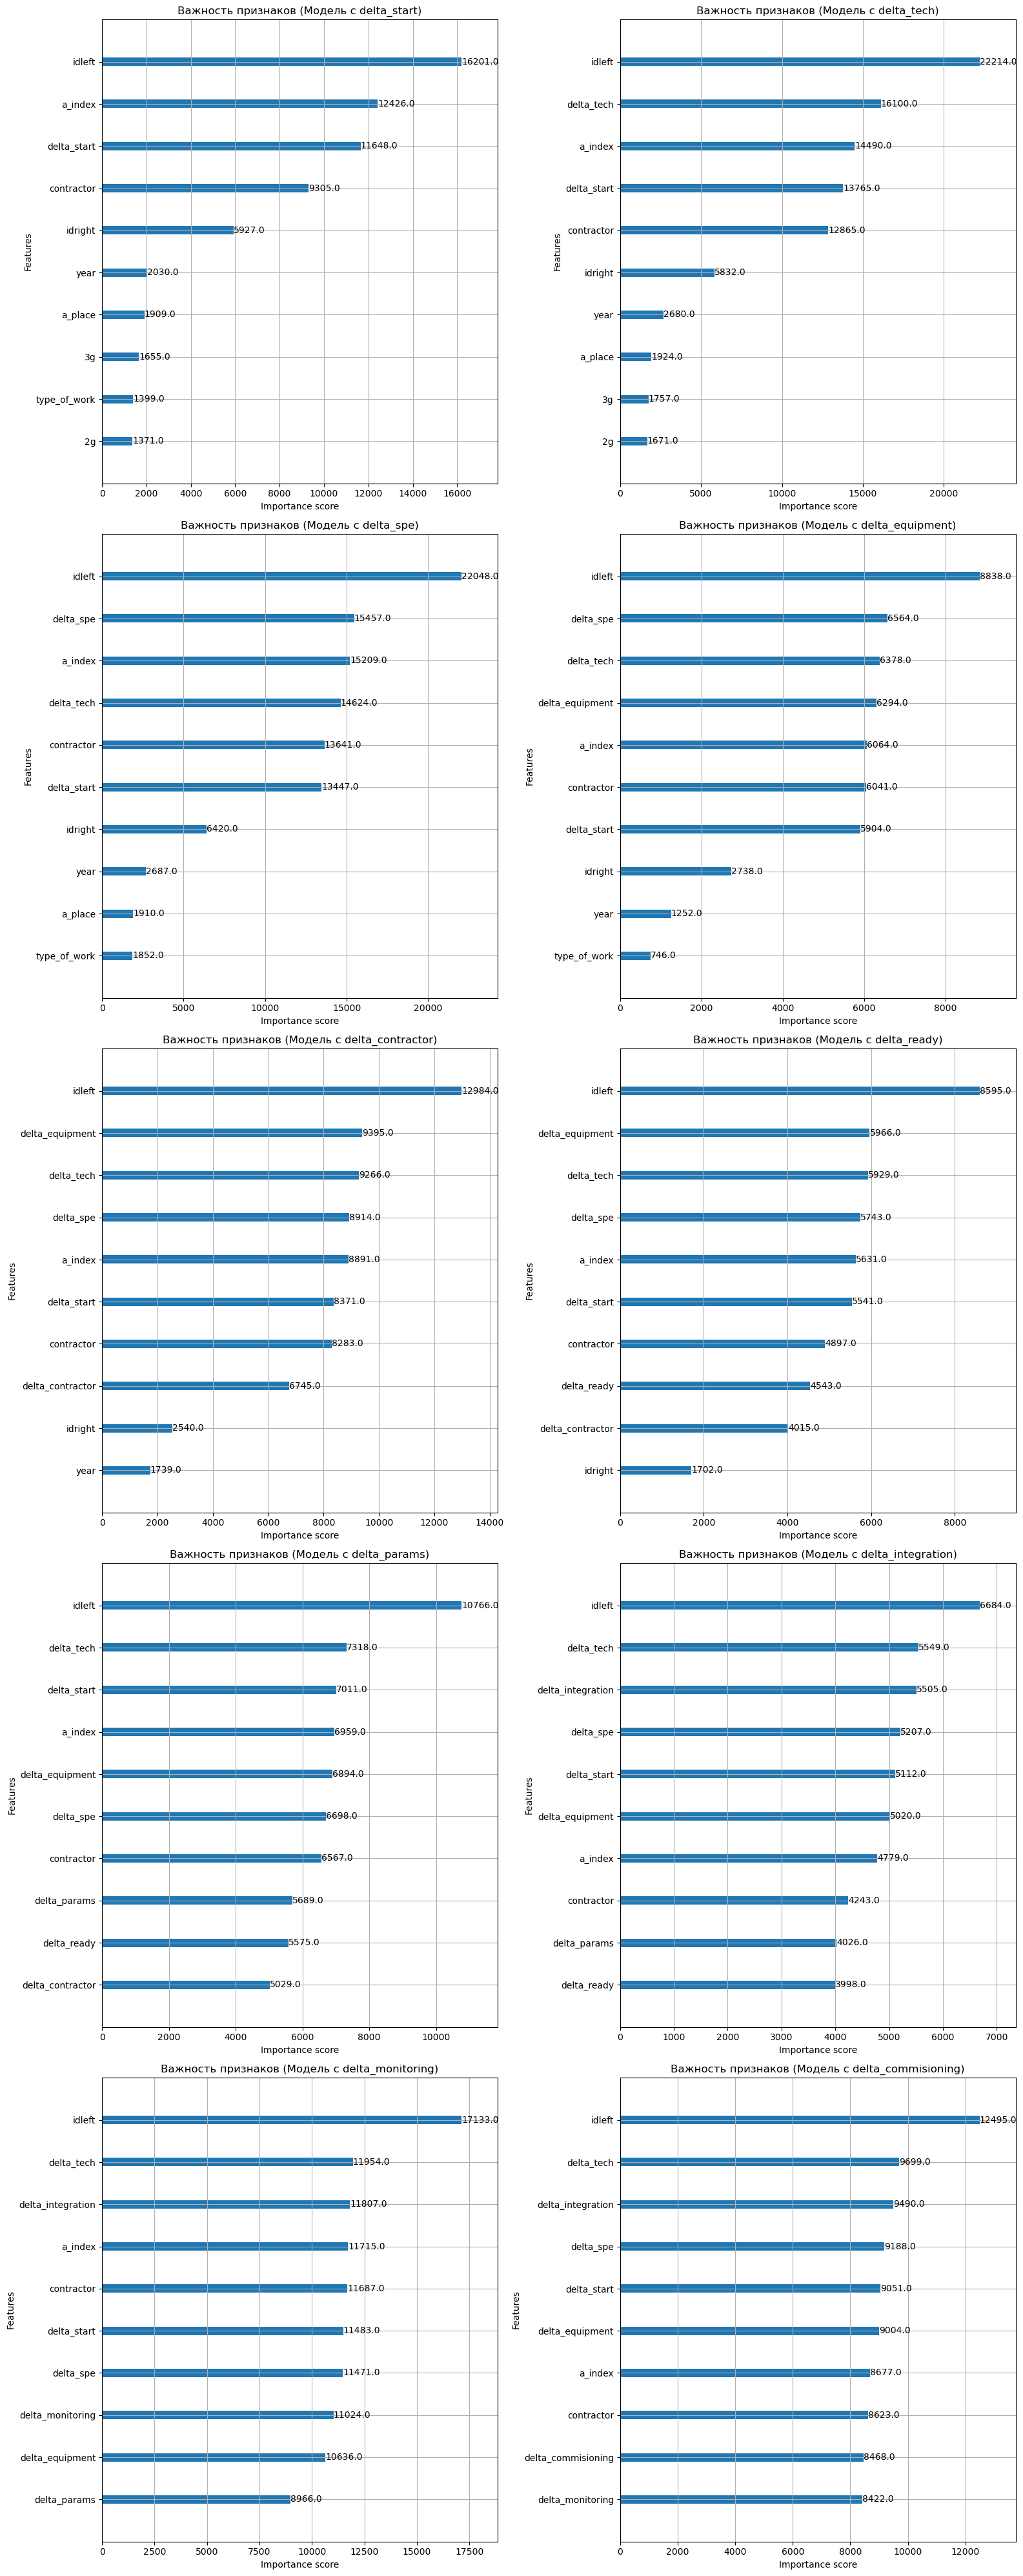

In [109]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 40))

# Проходим по всем моделям и осям
for idx, (model, ax) in enumerate(zip(xgb_models, axes.flatten())):
    xgb.plot_importance(model, ax=ax, max_num_features=10)
    ax.set_title(f"Важность признаков (Модель с {fields[idx + features]})")

# Убираем лишние оси, если моделей меньше чем subplots
if len(xgb_models) < 5*2:
    for j in range(len(xgb_models), 5*2):
        axes.flatten()[j].axis('off')

plt.tight_layout()
plt.show()

## Оценка метрик качества

In [115]:
models = ['LinearRegression', 'RandomForest', 'XGBoost']
rows = []
for model, model_data in zip(models, metrics):
    rows.append({'model': model, 'metrics': 'MAE', **{f'{fields[features+i]}': val[0] for i, val in enumerate(model_data)}})
    rows.append({'model': model, 'metrics': 'R2', **{f'{fields[features+i]}': val[1] for i, val in enumerate(model_data)}})
result_df = pd.DataFrame(rows)
average_df = result_df.iloc[:, 2:].mean(axis=1)
result_df

,model,metrics,delta_start,delta_tech,delta_spe,delta_equipment,delta_contractor,delta_ready,delta_params,delta_integration,delta_monitoring,delta_commisioning
0,LinearRegression,MAE,92.609013,51.147912,33.557495,31.433563,31.390799,27.970263,27.000443,20.316744,20.216525,15.918058
1,LinearRegression,R2,0.578895,0.842633,0.925458,0.934392,0.934541,0.945606,0.949182,0.960588,0.961652,0.971010
2,RandomForest,MAE,46.680380,29.462298,23.385902,22.538913,22.092643,20.950492,21.490633,20.880762,18.020890,21.783958
3,RandomForest,R2,0.861373,0.933070,0.953903,0.956564,0.956870,0.959608,0.958577,0.961675,0.964513,0.959130
4,XGBoost,MAE,47.842237,29.852947,23.619923,22.397606,21.304948,20.315469,20.454910,16.342203,16.492175,15.118602
5,XGBoost,R2,0.851021,0.929951,0.952244,0.954116,0.956976,0.960261,0.959536,0.966337,0.969328,0.972012


In [117]:
average_df

0    35.156082
1     0.900396
2    24.728687
3     0.946528
4    23.374102
5     0.947178
dtype: float64

В сравнительной таблице приведены значения MAE и R2-score для различных моделей используемых при решении описываемой задачи. В таблице MAE показывает ошибку в днях при предсказании длительности строительства объекта связи, R2 показывает насколько хорошо модель регрессии объясняет вариацию зависимой переменной. Напомним, что для успешного выполнения задач разрабатываемой системы на начальном этапе, когда у нас есть только информации о дате старта строительства объекта связи, достаточно точности для предсказания квартала оконочания строительства, то есть допустимая величина MAE составляет около 90 дней. В момент когда появляется дата о выдаче оборудования delta_equipment прогнозирование должно улучшиться и давать прогнозы с точностью до 7 дней.<br /> 
Все три модели показали приемлемый, но не идеальный результат по MAE. Ожидаемо линейная регрессия дала худшие результаты. Результаты XGBoost и RandomForest конкурируют между собой. XGBoost по сравнению с RandomForest дает хуже MAE и R2 в начале технологического процесса, но при этом, так же незначительно, выигрывает в конце. При выборе между последними двумя моделями предпочтение отдается XGBoost по следующим соображениям:
1. Средние значения average MAE и average R2 по всем моделям лучше у XGBoost MAE: $23.374102_{XGBoost}<24.728687_{RandomForest}$, $0.947178_{XGBoost}>0.946528_{RandomForest}$.
2. Более точные прогнозы в конце прогнозируемого технологического процесса, когда точность играет более важную роль, у XGBoost.
3. Меньший размер моделей, единицы мегабайт у XGBoost против сотен у RandomForest.
4. Меньшая склонность к переобучению у XGBoost.

Baseline: в качестве бейзлайна берем значения MAE и R2 для XGBoost из 4 и 5 строк сравнительной таблицы. Задача уменьшить MAE, особенно на базе фич, появляющихся после delta_equipment.

Шаги по дальнейшему улучшению модели:
1. Увеличить значимость "постоянных" фич модели путем добавления дополнительных признаков о месте размещении объектов связи, например, координаты.
2. Разбиение на кластера и обучение отдельных моделей под кажды кластер.
3. Добавление дополнительных признаков к delta_equipment, например, количество выдач оборудования.
4. Увеличение выборки, например, добавление дополнительных регионов, других лет и т.д.